# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme

(EDITED BY JOHN and Guwei)

## Group Members
- John Kim (1079731)
- Guwei Ke
- Lanye Shao (1475378)

## Overview

This notebook contains codes to run the climate claim classification model.

## Usage

To run the model, please follow the steps below:
1. Install jupyter notebook, if you haven't already. You can either use docker or install it directly on your machine. You can even use Google Colab to run the notebook.
2. We have pip requirements in the block below, so you can run the whole notebook to install the required packages.
3. Datasets will be automatically downloaded when you run the notebook. The dataset is quite large, so it may take some time to download.

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
# Below is a script to install the required packages for the project. (Similar to requirements.txt)

%pip install sentence-transformers
%pip install faiss-gpu
%pip install datasets
%pip install gdown
%pip install accelerate
%pip install transformers[torch]
%pip install huggingface_hub[hf_xet]
%pip install seaborn
%pip install matplotlib

ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


In [ ]:
import faiss
from sentence_transformers import CrossEncoder
from sentence_transformers import InputExample, SentenceTransformer, losses
from torch.utils.data import DataLoader
import random
import torch
import pandas as pd
import json
import re
import os
import gdown


In [ ]:
# This allows you to download files from Google Drive directly into your Colab environment. these files are stored in John's google drive.

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# # File Path
# data_dir = "/content/drive/MyDrive/COMP90042-Data"


# URLs of the files to download
urls = [
    "https://drive.google.com/uc?id=1SIlHpjPhgr5NJpf6nK79aCevoOmvZgML",
    "https://drive.google.com/uc?id=1aTH-Zzq9dztxxXIPDW8MY3HZR_6pGbSt",
    "https://drive.google.com/uc?id=1iliVuUhHp2M48Svxl2FUa4hWaOxnnTo7",
    "https://drive.google.com/uc?id=1-AWc4xhd7YVV45tOti9Uu778x4YCsyeZ",
    "https://drive.google.com/uc?id=1zvWH6i6EQwTVgFlaKfNm6TXeo6DEEA9m"
]

# Corresponding filenames
filenames = [
    "evidence.json",
    "dev-claims.json",
    "train-claims.json",
    "test-claims-unlabelled.json",
    "dev-claims-baseline.json"
]

# Download each file
for url, filename in zip(urls, filenames):
    if not os.path.exists(filename):
        gdown.download(url, filename, quiet=False)
    else:
        print(f"{filename} already exists. Skipping download.")

evidence.json already exists. Skipping download.
dev-claims.json already exists. Skipping download.
train-claims.json already exists. Skipping download.
test-claims-unlabelled.json already exists. Skipping download.
dev-claims-baseline.json already exists. Skipping download.


In [ ]:
def retrieve(evi_ebds, claim_ebds, evi_df, claim_df, retrival_top_k, rerank_top_k,threshold_activated,score_threshold, cross_encoder,dev):
    embedding_dim = evi_ebds.shape[1]
    index = faiss.IndexFlatL2(embedding_dim)
    faiss.normalize_L2(evi_ebds)
    index.add(evi_ebds)
    retrieval = pd.DataFrame()
    retrieved_labels = []
    retrieved_evidences = []

    i = 0
    counts = 0
    claim_texts = []
    total = len(claim_ebds)
    for dev_claim_embedding in claim_ebds:
        faiss.normalize_L2(dev_claim_embedding.reshape(1, -1))
        D, I = index.search(dev_claim_embedding.reshape(1, -1), retrival_top_k)
        text = claim_df.iloc[i]['claim_text']
        pairs = [(text, evi_df['value'][a]) for a in I[0]]
        scores = cross_encoder.predict(pairs)
        reranked = sorted(zip(I[0], scores), key=lambda x: x[1], reverse=True)

        retrieved_evidence = []
        filtered = []
        first = True
        for idx, score in reranked[:rerank_top_k]:
            if first:
                evi_id = evi_df['ID'][idx]
                evi_content = evi_df['value'][idx]
                retrieved_evidence.append(evi_id)
                filtered.append((evi_id, score, evi_content))
                first = False
            else:
                if not threshold_activated or score >= score_threshold:
                    evi_id = evi_df['ID'][idx]
                    evi_content = evi_df['value'][idx]
                    retrieved_evidence.append(evi_id)
                    filtered.append((evi_id, score, evi_content))

        retrieved_evi =  [evi_df['ID'][a] for a in I[0]]
        retrieved_evidences.append(retrieved_evidence)
        retrieved_labels.append('SUPPORTS')
        claim_texts.append(text)

        if dev:
            print(f"Claim: {text}")
            if len(filtered) > 0:
                print("evidence relevant")
                for eid, score, c in filtered:
                    print(f"  {eid}, Score: {score:.4f} ")
            print(f"Ground truth: {claim_df.iloc[i]['evidences']}\n")

            count = 0
            for g in claim_df.iloc[i]['evidences']:
                if g in retrieved_evi:
                    count += 1
            counts += count / len(claim_df.iloc[i]['evidences'])

        print('Progress ', round(i * 100 / total, 3), '%')
        i += 1

    print("R: ", counts/ i)

    # Create the dataframe with all necessary information
    retrieval['ID'] = claim_df['ID'].values[:len(retrieved_evidences)]
    retrieval['evidences'] = retrieved_evidences
    retrieval['claim_label'] = retrieved_labels
    retrieval['claim_text'] = claim_texts

    return retrieval

def mine_hard_negatives(retrieved_evidences, ground_truth_evidences):
    negative_evidences = []
    for i in range(len(retrieved_evidences)):
        retrieved_evidence = retrieved_evidences.iloc[i]
        ground_truth_evidence = ground_truth_evidences.iloc[i]
        negative_evidence = []
        for e in retrieved_evidence:
            if e not in ground_truth_evidence:
                negative_evidence.append(int(re.findall(r'\d+', e)[0]))
        negative_evidences.append(negative_evidence)
    return negative_evidences

def load_train_data(train_dataframe, evidence_dateframe, random_negatives_amount_per_claim):
    train_data = []
    for id in range(len(train_dataframe)):
        claim_text =  train_dataframe.iloc[id]['claim_text']
        # print("CLAIM: ", claim_text)
        positive_evidence_ids = train_dataframe.iloc[id]['evidences_numeric_index']
        negative_evidence_ids = train_dataframe.iloc[id]['negative_evidences']
        for evid_id in positive_evidence_ids:

            evidence_text = evidence_dateframe.iloc[evid_id]['value']
            # print("POSITIVE: ", evidence_text)
            train_data.append(InputExample(texts=[claim_text, evidence_text], label=1.0))
        for ngevid_id in negative_evidence_ids:
            evidence_text = evidence_dateframe.iloc[ngevid_id]['value']
            # print("NEGATIVE: ", evidence_text)
            train_data.append(InputExample(texts=[claim_text, evidence_text], label=0.0))

        for i in range(random_negatives_amount_per_claim):
            neg_id = random.choice(list(set(evidence_dateframe.index) - set(positive_evidence_ids)))
            neg_text = evidence_dateframe.iloc[neg_id]['value']
            train_data.append(InputExample(texts=[claim_text, neg_text], label=0.0))
    return train_data

def load_positive_train_data(train_dataframe, evidence_dateframe):
    train_data = []
    for id in range(len(train_dataframe)):
        claim_text =  train_dataframe.iloc[id]['claim_text']
        positive_evidence_ids = train_dataframe.iloc[id]['evidences_numeric_index']
        for evid_id in positive_evidence_ids:
            evidence_text = evidence_dateframe.iloc[evid_id]['value']
            train_data.append(InputExample(texts=[claim_text, evidence_text], label=1.0))
    return train_data

def save_retrieval(retrieval, path):
    output = {}
    for i in range(len(retrieval)):
        output[retrieval.iloc[i]['ID']] = {}
        output[retrieval.iloc[i]['ID']]['evidences'] = retrieval.iloc[i]['evidences']
        output[retrieval.iloc[i]['ID']]['claim_label'] = retrieval.iloc[i]['claim_label']
        output[retrieval.iloc[i]['ID']]['claim_text'] = retrieval.iloc[i]['claim_text']

    with open(path, 'w') as file:
        file.write(json.dumps(output))

Read evidence dataset.

In [ ]:
with open('evidence.json', 'r') as f:
    evidence = json.load(f)
flat_list = []
for key in evidence:
    flat_list.append({"ID": key, "value": evidence[key]})

evidence_df = pd.DataFrame(flat_list)

evidence_df.head()

,ID,value
0,evidence-0,"John Bennet Lawes, English entrepreneur and ag..."
1,evidence-1,Lindberg began his professional career at the ...
2,evidence-2,``Boston (Ladies of Cambridge)'' by Vampire We...
3,evidence-3,"Gerald Francis Goyer (born October 20, 1936) w..."
4,evidence-4,He detected abnormalities of oxytocinergic fun...


Read training and developing datasets

In [ ]:
with open('train-claims.json', 'r') as f:
    train_df = json.load(f)
flat_list = []
for key in train_df:
    evidences_numeric_index = []
    for e in train_df[key]['evidences']:
        evidences_numeric_index.append(int(re.findall(r'\d+', e)[0]))
    flat_list.append({"ID": key, "claim_text": train_df[key]['claim_text'], "claim_label": train_df[key]['claim_label'], "evidences": train_df[key]['evidences'], "evidences_numeric_index": evidences_numeric_index})
train_df = pd.DataFrame(flat_list)

train_df.head()



,ID,claim_text,claim_label,evidences,evidences_numeric_index
0,claim-1937,Not only is there no scientific evidence that ...,DISPUTED,"[evidence-442946, evidence-1194317, evidence-1...","[442946, 1194317, 12171]"
1,claim-126,El Niño drove record highs in global temperatu...,REFUTES,"[evidence-338219, evidence-1127398]","[338219, 1127398]"
2,claim-2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,"[evidence-530063, evidence-984887]","[530063, 984887]"
3,claim-2021,Weather Channel co-founder John Coleman provid...,DISPUTED,"[evidence-1177431, evidence-782448, evidence-5...","[1177431, 782448, 540069, 352655, 1007867]"
4,claim-2449,"""January 2008 capped a 12 month period of glob...",NOT_ENOUGH_INFO,"[evidence-1010750, evidence-91661, evidence-72...","[1010750, 91661, 722725, 554161, 430839]"


In [ ]:
with open('dev-claims.json', 'r') as f:
    dev_df = json.load(f)
flat_list = []
for key in dev_df:
    evidences_numeric_index = []
    for e in dev_df[key]['evidences']:
        evidences_numeric_index.append(int(re.findall(r'\d+', e)[0]))
    flat_list.append({"ID": key, "claim_text": dev_df[key]['claim_text'], "claim_label": dev_df[key]['claim_label'], "evidences": dev_df[key]['evidences'], "evidences_numeric_index": evidences_numeric_index})
dev_df = pd.DataFrame(flat_list)

dev_df.head()

,ID,claim_text,claim_label,evidences,evidences_numeric_index
0,claim-752,[South Australia] has the most expensive elect...,SUPPORTS,"[evidence-67732, evidence-572512]","[67732, 572512]"
1,claim-375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,"[evidence-996421, evidence-1080858, evidence-2...","[996421, 1080858, 208053, 699212, 832334]"
2,claim-1266,This means that the world is now 1C warmer tha...,SUPPORTS,"[evidence-889933, evidence-694262]","[889933, 694262]"
3,claim-871,"“As it happens, Zika may also be a good model ...",NOT_ENOUGH_INFO,"[evidence-422399, evidence-702226, evidence-28...","[422399, 702226, 286834, 472751, 641043]"
4,claim-2164,Greenland has only lost a tiny fraction of its...,REFUTES,"[evidence-52981, evidence-264761, evidence-947...","[52981, 264761, 947243, 424102]"


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

Calculate sentence embeddings for evidence dataset and trainning dataset.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

train_data = load_positive_train_data(train_df, evidence_df)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(model=model)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    output_path='./output-bi-encoder',
    weight_decay=0.01
)

evidence_embeddings = model.encode(evidence_df['value'], batch_size=64, show_progress_bar=True)
dev_claims_embeddings = model.encode(dev_df['claim_text'], batch_size=64, show_progress_bar=True)
train_claims_embeddings = model.encode(train_df['claim_text'], batch_size=64, show_progress_bar=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: kakwak123 (kakwak123-the-university-of-melbourne) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.902100


Batches:   0%|          | 0/18888 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Fine tune cross encoder for re-ranking.

In [ ]:
from datasets import Dataset
def load_positive_train_ds(train_dataframe, evidence_dateframe, t_ebds, e_ebds):
    query = []
    answer = []
    for id in range(len(train_dataframe)):
        claim_text =  train_dataframe.iloc[id]['claim_text']
        positive_evidence_ids = train_dataframe.iloc[id]['evidences_numeric_index']
        # claim_ebd = t_ebds[id]
        # none_added = True
        for evid_id in positive_evidence_ids:

            # evi_ebd = e_ebds[evid_id]
            evidence = evidence_dateframe.iloc[evid_id]['value']
            # similarities = model.similarity(claim_ebd, evi_ebd)

            # if similarities > 0:
            #     none_added = False
            # print('Claim: ', claim_text)
            # print('Evidence: ', evidence)

            query.append(claim_text)
            answer.append(evidence)
        # if none_added:
        #     query.append(claim_text)
        #     answer.append(evidence_dateframe.iloc[positive_evidence_ids[0]]['value'])

    return Dataset.from_dict({
    "query": query,
    "answer": answer,})


train_dataset = load_positive_train_ds(train_df, evidence_df, train_claims_embeddings, evidence_embeddings)
print(len(train_dataset))

4122


In [ ]:
from sentence_transformers.cross_encoder.evaluation import CrossEncoderRerankingEvaluator
from sentence_transformers.cross_encoder import CrossEncoderTrainingArguments, CrossEncoderTrainer, losses
from sentence_transformers.util import mine_hard_negatives

eval_dataset = load_positive_train_ds(dev_df, evidence_df,dev_claims_embeddings, evidence_embeddings)
device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model = SentenceTransformer("sentence-transformers/static-retrieval-mrl-en-v1", device=device)
hard_eval_dataset = mine_hard_negatives(
    eval_dataset,
    embedding_model,
    corpus = train_dataset["answer"],  # Use the full dataset as the corpus
    num_negatives=50,  # How many negatives per question-answer pair
    batch_size=4096,  # Use a batch size of 4096 for the embedding model
    output_format="n-tuple",  # The output format is (query, positive, negative1, negative2, ...) for the evaluator
    include_positives=True,  # Key: Include the positive answer in the list of negatives
    use_faiss=True,  # Using FAISS is recommended to keep memory usage low (pip install faiss-gpu or pip install faiss-cpu)
)

reranking_evaluator = CrossEncoderRerankingEvaluator(
    samples=[
        {
            "query": sample["query"],
            "positive": [sample["answer"]],
            "documents": [sample[column_name] for column_name in hard_eval_dataset.column_names[2:]],
        }
        for sample in hard_eval_dataset
    ],
    batch_size=32,
    name="gooaq-dev",
)

Setting range_max to 55 based on the provided parameters.
Found 154 unique queries out of 491 total queries.
Found an average of 3.188 positives per query.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Querying FAISS index: 100%|██████████| 1/1 [00:00<00:00, 45.38it/s]


Metric       Positive       Negative     Difference
Count             491         24,550               
Mean           0.4280         0.4167         0.0114
Median         0.4312         0.4152         0.0053
Std            0.1499         0.1238         0.1363
Min            0.0165         0.1251        -0.5122
25%            0.3265         0.3309        -0.0782
50%            0.4312         0.4152         0.0053
75%            0.5316         0.5089         0.0986
Max            0.7839         0.8124         0.5326


In [ ]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

reranking_evaluator(cross_encoder)


model_name = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
short_model_name = model_name if "/" not in model_name else model_name.split("/")[-1]
run_name = f"reranker-{short_model_name}-gooaq-cmnrl"
args = CrossEncoderTrainingArguments(
    # Required parameter:
    output_dir=f"models/{run_name}",
    # Optional training parameters:
    num_train_epochs= 3,
    per_device_train_batch_size= 8,
    per_device_eval_batch_size= 8,
    learning_rate= 1e-5,
    warmup_ratio=0.1,
    fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=True,  # Set to True if you have a GPU that supports BF16
    # Optional tracking/debugging parameters:
    eval_strategy="epoch",
    save_strategy="epoch",

    save_total_limit=2,
    run_name=run_name,  # Will be used in W&B if `wandb` is installed
    seed=12,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    weight_decay = 0.01,
)
loss = losses.MultipleNegativesRankingLoss(model=cross_encoder)

trainer = CrossEncoderTrainer(
    model=cross_encoder,
    args=args,train_dataset
    train_dataset=train_dataset,
    loss=loss,
    evaluator=reranking_evaluator,
    eval_dataset=eval_dataset,
)
trainer.train()

# cross_encoder.fit(

#     train_dataloader=train_dataloader,
#     # loss_fct=train_loss,
#     epochs=20,
#     output_path='./fine-tuned-cross-encoder',
#     weight_decay=0.01
# )

Epoch,Training Loss,Validation Loss,Gooaq-dev Map,Gooaq-dev Mrr@10,Gooaq-dev Ndcg@10,Gooaq-dev Base Map,Gooaq-dev Base Mrr@10,Gooaq-dev Base Ndcg@10
1,0.427800,0.218383,0.320952,0.304256,0.393210,0.211680,0.200438,0.255458
2,0.225100,0.163419,0.325189,0.309096,0.400726,0.211680,0.200438,0.255458
3,0.185300,0.180082,0.326072,0.309773,0.401365,0.211680,0.200438,0.255458


TrainOutput(global_step=1548, training_loss=0.27716211139077673, metrics={'train_runtime': 399.5769, 'train_samples_per_second': 30.948, 'train_steps_per_second': 3.874, 'total_flos': 0.0, 'train_loss': 0.27716211139077673, 'epoch': 3.0})

Size to 8 to make google colab work

Second retrieve for testing.

In [ ]:
# train_retrieval = retrieve(evidence_embeddings, train_claims_embeddings, evidence_df , train_df, 150, 4, True, 2, cross_encoder, True)
# save_retrieval(train_retrieval, 'train_retrieval.json')

In [ ]:

dev_retrieval = retrieve(evidence_embeddings, dev_claims_embeddings, evidence_df , dev_df, 150, 5, True, 0, cross_encoder, True)
save_retrieval(dev_retrieval, 'dev_retrieval.json')


Claim: [South Australia] has the most expensive electricity in the world.
evidence relevant
  evidence-67732, Score: 8.1356 
  evidence-572512, Score: 8.0519 
  evidence-723533, Score: 5.4764 
  evidence-48256, Score: 5.4526 
  evidence-780332, Score: 5.2922 
Ground truth: ['evidence-67732', 'evidence-572512']

Progress  0.0 %
Claim: when 3 per cent of total annual global emissions of carbon dioxide are from humans and Australia prod­uces 1.3 per cent of this 3 per cent, then no amount of emissions reductio­n here will have any effect on global climate.
evidence relevant
  evidence-559290, Score: 4.6380 
  evidence-1182416, Score: 4.3034 
  evidence-430393, Score: 3.7864 
  evidence-215052, Score: 3.7419 
  evidence-631053, Score: 3.7215 
Ground truth: ['evidence-996421', 'evidence-1080858', 'evidence-208053', 'evidence-699212', 'evidence-832334']

Progress  0.649 %
Claim: This means that the world is now 1C warmer than it was in pre-industrial times
evidence relevant
  evidence-694262

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

I will do a classficiation, we were thinking of using transformer model then LSTM, and compare them and use the one with the best performance.
For transformer, in this fact checking task, I will first try with the multi encoder fusion because we have a lot of cluses in the evidence and want to combine


In [ ]:
with open('test-claims-unlabelled.json','r') as f:
    data = f.read()
print(data[:200])

test_df = json.loads(data)
flat_list = []
for key in test_df:
    flat_list.append({"ID": key, "claim_text": test_df[key]['claim_text']})
tst_df = pd.DataFrame(flat_list)
tst_claims_embeddings = model.encode(tst_df['claim_text'], batch_size=64, show_progress_bar=True)
retrieval = retrieve(evidence_embeddings, tst_claims_embeddings, evidence_df , tst_df, 150, 5, False, 0, cross_encoder, False)
save_retrieval(retrieval, 'test-output.json')


{"claim-2967": {"claim_text": "The contribution of waste heat to the global climate is 0.028 W/m2."}, "claim-979": {"claim_text": "\u201cWarm weather worsened the most recent five-year drought, which 


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Progress  0.0 %
Progress  0.654 %
Progress  1.307 %
Progress  1.961 %
Progress  2.614 %
Progress  3.268 %
Progress  3.922 %
Progress  4.575 %
Progress  5.229 %
Progress  5.882 %
Progress  6.536 %
Progress  7.19 %
Progress  7.843 %
Progress  8.497 %
Progress  9.15 %
Progress  9.804 %
Progress  10.458 %
Progress  11.111 %
Progress  11.765 %
Progress  12.418 %
Progress  13.072 %
Progress  13.725 %
Progress  14.379 %
Progress  15.033 %
Progress  15.686 %
Progress  16.34 %
Progress  16.993 %
Progress  17.647 %
Progress  18.301 %
Progress  18.954 %
Progress  19.608 %
Progress  20.261 %
Progress  20.915 %
Progress  21.569 %
Progress  22.222 %
Progress  22.876 %
Progress  23.529 %
Progress  24.183 %
Progress  24.837 %
Progress  25.49 %
Progress  26.144 %
Progress  26.797 %
Progress  27.451 %
Progress  28.105 %
Progress  28.758 %
Progress  29.412 %
Progress  30.065 %
Progress  30.719 %
Progress  31.373 %
Progress  32.026 %
Progress  32.68 %
Progress  33.333 %
Progress  33.987 %
Progress  34.641

In [ ]:
with open('test-output.json', 'r') as f:
    test_output = json.load(f)


I am going to initialise a transformer model and tokensizer for the evidence classification task.
My plan is to use fastest training times and speed as this is done from gooogle collab and our retrival already takes a lot of time which almost is 6 hours to train in colab unfortunately. We have enough disk space but I want to keep the training simple and most generic as possible.
There were few options, but we will go with distilbert-base-uncased, which is a smaller version of BERT.

Decisions based on cased and uncased is uncased because itt is faster and no need to worry about capital named entities.
{SUPPORTS, REFUTES, NOT_ENOUGH_INFO, DISPUTED} There are 4 classes in the evidence classification task.

I also want to keep the label order and everything simple as possible.


In [ ]:
# import that wasn't done in the beginning
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model choice and label list initialization
classifer_model = "distilbert-base-uncased"
label_list=["SUPPORTS", "REFUTES", "NOT_ENOUGH_INFO", "DISPUTED"]
num_labels = len(label_list)
label_map = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

print("Label Map: ", label_map)
print("ID to Label Map: ", id2label)

#load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(classifer_model)
model = AutoModelForSequenceClassification.from_pretrained(classifer_model, num_labels=num_labels, id2label=id2label, label2id=label_map)

Label Map:  {'SUPPORTS': 0, 'REFUTES': 1, 'NOT_ENOUGH_INFO': 2, 'DISPUTED': 3}
ID to Label Map:  {0: 'SUPPORTS', 1: 'REFUTES', 2: 'NOT_ENOUGH_INFO', 3: 'DISPUTED'}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


For preparing training data from claims for the ground truth evidence, I will be using  one training instance per evidence.
E.g.
1. (claim_tex [SEP] evidence_text_1, "SUPPORTS")
2. (claim_text [SEP] evidence_text_2, "SUPPORTS")
3. (claim_text [SEP] evidence_text_3, "REFUTES")
4. (claim_text [SEP] evidence_text_4, "NOT_ENOUGH_INFO")
5. (claim_text [SEP] evidence_text_5, "DISPUTED")

Kind of ways, because this is the best way to train data for the model.

Some options we considered were: only using one of the randomly selected evidence or first evidence.
Or put all evidenece in one instance.

We will also use PyTorch for the training to do it manually instead of huggingface trainer.

Hyperparameters for the training:
- learning_rate = ADAMW(1e-5) Optimizer
- batch_size = 16
- epochs = 10

We will use dev-claims for validation and test-claims for testing.

We will try to look for f score and accuracy for the evaluation.

For the ones that has label but no listed evidence, we will create a special input format like
(claim_text [SEP], "NOT_ENOUGH_INFO") since we are not allowed to modify the dataset or can't skip it written in the project description.
claims labllee

Also later changed to tokenizers real separator (tokenizer.sep_token) in order to learn the model better.

Also I added a checkpoint to train fixed 10 epochs and save the best model by tracking the best accuracy.



In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from tqdm import tqdm

# custom pytorch dataset class
class ClaimEvidenceDataset(Dataset):
    def __init__(self, data_list, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.texts = [item['text'] for item in data_list]
        self.labels = [item['label_id'] for item in data_list]
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids':      encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels':         torch.tensor(self.labels[idx], dtype=torch.long)
        }

# function to match the evidence with the claim and prepare the dataset using separator
def prepare_data(df, evidence_df, label_map):
    items = []
    for _, row in df.iterrows():
        claim_text = row['claim_text']
        for evid_id in row.get('evidences', []):
            evid_row = evidence_df[evidence_df['ID'] == evid_id]
            if evid_row.empty:
                continue
            # [SEP] token is used to separate claim and evidence
            text = f"{claim_text} {tokenizer.sep_token} {evid_row['value'].iloc[0]}"
            label = label_map[row['claim_label']]
            items.append({'text': text, 'label_id': label})
    return items

# build datasets and dataloaders
train_items = prepare_data(train_df, evidence_df, label_map)
dev_items   = prepare_data(dev_df,   evidence_df, label_map)

# print to debug it is working simple
print("Done preparing daata: ", len(train_items), " train items and ", len(dev_items), " dev items")

train_dataset = ClaimEvidenceDataset(train_items, tokenizer)
dev_dataset   = ClaimEvidenceDataset(dev_items,   tokenizer)

# print to debug the claimevidence dataset is working
print("Train Dataset: ", train_dataset[0])
print("Dev Dataset: ", dev_dataset[0])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader   = DataLoader(dev_dataset,   batch_size=16)



Done preparing daata:  4122  train items and  491  dev items
Train Dataset:  {'input_ids': tensor([  101,  2025,  2069,  2003,  2045,  2053,  4045,  3350,  2008,  2522,
         2475,  2003,  1037,  8554, 13210,  3372,  1010,  3020,  2522,  2475,
        14061,  2941,  2393, 20440,  2490,  2062,  3269,  1998,  4111,  2166,
         1012,   102,  2012,  2200,  2152, 14061,  1006,  2531,  2335, 12483,
         6693,  1010,  2030,  3618,  1007,  1010,  6351, 14384,  2064,  2022,
        11704,  2000,  4111,  2166,  1010,  2061,  6274,  1996,  6693,  2000,
         2184,  1010,  2199,  4903,  2213,  1006,  1015,  1003,  1007,  2030,
         3020,  2005,  2195,  2847,  2097, 11027, 20739,  2015,  2107,  2004,
         2317, 24019,  1998,  6804, 10210,  2229,  1999,  1037, 16635,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  

Starting training on cuda
Number of training examples: 4122
Number of validation examples: 491
Number of epochs: 10


Training: 100%|██████████| 258/258 [00:46<00:00,  5.55it/s]


Epoch 1 Train loss: 0.0105


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.06it/s]


Dev acc: 0.4053, F1: 0.3572
                 precision    recall  f1-score   support

       SUPPORTS       0.43      0.83      0.56       171
        REFUTES       0.18      0.14      0.16        57
NOT_ENOUGH_INFO       0.57      0.20      0.30       205
       DISPUTED       0.18      0.12      0.14        58

       accuracy                           0.41       491
      macro avg       0.34      0.32      0.29       491
   weighted avg       0.43      0.41      0.36       491

New best F1: 0.3572


Training: 100%|██████████| 258/258 [00:45<00:00,  5.65it/s]


Epoch 2 Train loss: 0.0059


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.60it/s]


Dev acc: 0.4257, F1: 0.4047
                 precision    recall  f1-score   support

       SUPPORTS       0.45      0.72      0.55       171
        REFUTES       0.22      0.39      0.28        57
NOT_ENOUGH_INFO       0.58      0.27      0.37       205
       DISPUTED       0.38      0.16      0.22        58

       accuracy                           0.43       491
      macro avg       0.41      0.38      0.36       491
   weighted avg       0.47      0.43      0.40       491

New best F1: 0.4047


Training: 100%|██████████| 258/258 [00:45<00:00,  5.62it/s]


Epoch 3 Train loss: 0.0128


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 16.67it/s]


Dev acc: 0.3890, F1: 0.3411
                 precision    recall  f1-score   support

       SUPPORTS       0.43      0.75      0.55       171
        REFUTES       0.23      0.47      0.31        57
NOT_ENOUGH_INFO       0.61      0.14      0.22       205
       DISPUTED       0.26      0.14      0.18        58

       accuracy                           0.39       491
      macro avg       0.38      0.37      0.31       491
   weighted avg       0.46      0.39      0.34       491



Training: 100%|██████████| 258/258 [00:45<00:00,  5.64it/s]


Epoch 4 Train loss: 0.0029


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.25it/s]


Dev acc: 0.4644, F1: 0.4472
                 precision    recall  f1-score   support

       SUPPORTS       0.48      0.73      0.58       171
        REFUTES       0.27      0.30      0.28        57
NOT_ENOUGH_INFO       0.57      0.38      0.45       205
       DISPUTED       0.29      0.16      0.20        58

       accuracy                           0.46       491
      macro avg       0.40      0.39      0.38       491
   weighted avg       0.47      0.46      0.45       491

New best F1: 0.4472


Training: 100%|██████████| 258/258 [00:45<00:00,  5.64it/s]


Epoch 5 Train loss: 0.0009


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.20it/s]


Dev acc: 0.4644, F1: 0.4501
                 precision    recall  f1-score   support

       SUPPORTS       0.47      0.70      0.56       171
        REFUTES       0.28      0.35      0.31        57
NOT_ENOUGH_INFO       0.58      0.39      0.46       205
       DISPUTED       0.32      0.16      0.21        58

       accuracy                           0.46       491
      macro avg       0.41      0.40      0.39       491
   weighted avg       0.48      0.46      0.45       491

New best F1: 0.4501


Training: 100%|██████████| 258/258 [00:45<00:00,  5.63it/s]


Epoch 6 Train loss: 0.0012


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.47it/s]


Dev acc: 0.4521, F1: 0.4392
                 precision    recall  f1-score   support

       SUPPORTS       0.51      0.67      0.58       171
        REFUTES       0.25      0.26      0.26        57
NOT_ENOUGH_INFO       0.49      0.40      0.44       205
       DISPUTED       0.26      0.16      0.19        58

       accuracy                           0.45       491
      macro avg       0.38      0.37      0.37       491
   weighted avg       0.44      0.45      0.44       491



Training: 100%|██████████| 258/258 [00:45<00:00,  5.63it/s]


Epoch 7 Train loss: 0.0030


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 16.84it/s]


Dev acc: 0.4460, F1: 0.4270
                 precision    recall  f1-score   support

       SUPPORTS       0.47      0.74      0.57       171
        REFUTES       0.28      0.37      0.32        57
NOT_ENOUGH_INFO       0.61      0.30      0.41       205
       DISPUTED       0.21      0.16      0.18        58

       accuracy                           0.45       491
      macro avg       0.39      0.39      0.37       491
   weighted avg       0.48      0.45      0.43       491



Training: 100%|██████████| 258/258 [00:45<00:00,  5.63it/s]


Epoch 8 Train loss: 0.0003


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 16.33it/s]


Dev acc: 0.4501, F1: 0.4324
                 precision    recall  f1-score   support

       SUPPORTS       0.47      0.73      0.57       171
        REFUTES       0.28      0.37      0.32        57
NOT_ENOUGH_INFO       0.59      0.32      0.42       205
       DISPUTED       0.24      0.16      0.19        58

       accuracy                           0.45       491
      macro avg       0.39      0.39      0.37       491
   weighted avg       0.47      0.45      0.43       491



Training: 100%|██████████| 258/258 [00:45<00:00,  5.63it/s]


Epoch 9 Train loss: 0.0054


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.38it/s]


Dev acc: 0.3340, F1: 0.3257
                 precision    recall  f1-score   support

       SUPPORTS       0.49      0.59      0.54       171
        REFUTES       0.19      0.42      0.26        57
NOT_ENOUGH_INFO       0.55      0.14      0.22       205
       DISPUTED       0.09      0.17      0.12        58

       accuracy                           0.33       491
      macro avg       0.33      0.33      0.29       491
   weighted avg       0.43      0.33      0.33       491



Training: 100%|██████████| 258/258 [00:45<00:00,  5.63it/s]


Epoch 10 Train loss: 0.0212


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.30it/s]


Dev acc: 0.4155, F1: 0.4082
                 precision    recall  f1-score   support

       SUPPORTS       0.48      0.68      0.56       171
        REFUTES       0.23      0.32      0.27        57
NOT_ENOUGH_INFO       0.61      0.29      0.39       205
       DISPUTED       0.13      0.16      0.14        58

       accuracy                           0.42       491
      macro avg       0.36      0.36      0.34       491
   weighted avg       0.46      0.42      0.41       491

Best model saved to claim_evidence_classifier.pth with F1: 0.4501


,epoch,train_loss,val_accuracy,val_f1
0,1,0.010508,0.405295,0.357210
1,2,0.005938,0.425662,0.404722
2,3,0.012814,0.389002,0.341123
3,4,0.002921,0.464358,0.447165
4,5,0.000858,0.464358,0.450097
5,6,0.001166,0.452138,0.439205
6,7,0.003030,0.446029,0.427038
7,8,0.000252,0.450102,0.432359
8,9,0.005436,0.334012,0.325652
9,10,0.021169,0.415479,0.408171


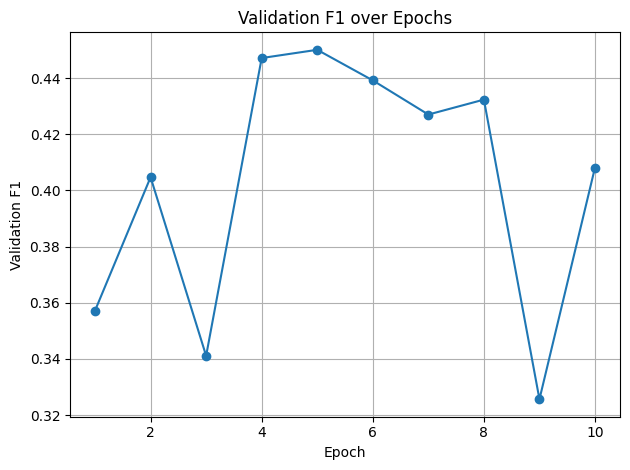

In [ ]:
def train_one_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, dev_loader, device, label_names):
    model.eval()
    preds, trues = [], []
    for batch in tqdm(dev_loader, desc="Evaluating"):
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().tolist())
        trues.extend(labels.cpu().tolist())
    acc = accuracy_score(trues, preds)
    _, _, f1, _ = precision_recall_fscore_support(trues, preds, average="weighted")
    print(f"Dev acc: {acc:.4f}, F1: {f1:.4f}")
    print(classification_report(trues, preds, target_names=label_names))
    return acc, f1

def train_and_evaluate(model, train_loader, dev_loader, optimizer, device, epochs, label_names, save_path="model_best.pth"):
    train_losses, val_accs, val_f1s = [], [], []
    best_f1 = 0.0
    best_state = None
    for epoch in range(1, epochs + 1):
        loss = train_one_epoch(model, train_loader, optimizer, device)
        train_losses.append(loss)
        print(f"Epoch {epoch} Train loss: {loss:.4f}")
        acc, f1 = evaluate_model(model, dev_loader, device, label_names)
        val_accs.append(acc)
        val_f1s.append(f1)
        if f1 > best_f1:
            best_f1 = f1
            best_state = model.state_dict().copy()
            print(f"New best F1: {best_f1:.4f}")
    if best_state:
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved to {save_path} with F1: {best_f1:.4f}")

    return train_losses, val_accs, val_f1s


# Set training parameters
num_epochs = 10
learning_rate = 1e-5

# move the model to the device for gpu
model.to(device)

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Print training info
print(f"Starting training on {device}")
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(dev_dataset)}")
print(f"Number of epochs: {num_epochs}")

# Train and evaluate model
train_losses, val_accs, val_f1s = train_and_evaluate(
    model=model,
    train_loader=train_loader,
    dev_loader=dev_loader,
    optimizer=optimizer,
    device=device,
    epochs=num_epochs,
    label_names=label_list,
    save_path="claim_evidence_classifier.pth"
)

# Load the best model for further use
model.load_state_dict(torch.load("claim_evidence_classifier.pth"))

# Display training results
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "epoch":      list(range(1, num_epochs+1)),
    "train_loss": train_losses,
    "val_accuracy": val_accs,
    "val_f1":     val_f1s
})
display(df)

# Plot Validation F1 over epochs
plt.figure()
plt.plot(df["epoch"], df["val_f1"], marker='o')
plt.title("Validation F1 over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation F1")
plt.grid(True)
plt.tight_layout()
plt.show()


Now I am going to load the best model state to store in state_dict to a file

Also I will now need to prepare and batch the test data for prediction and for that I will use pytorch dataset and dataloader for convenience consistency and speed as google collab is slow

In [ ]:
# evidence_df
# dev_df
# train_df
# tst_df
# test_df

In [ ]:
# function to prepare test data
def prepare_test_data(claim_text, evidences, evidence_df):
    items = []
    for evid_id in evidences:
        evid_row = evidence_df[evidence_df['ID'] == evid_id]
        if evid_row.empty:
            continue
        text = f"{claim_text} {tokenizer.sep_token} {evid_row['value'].iloc[0]}"
        items.append({'text': text})
    return items

# function to predict labels
def predict_claim_label(model, items, tokenizer, device):
    model.eval()

    # If no evidence, return NOT_ENOUGH_INFO
    if not items:
        return "NOT_ENOUGH_INFO"

    # Create a dataset and dataloader for the items
    class PredictionDataset(Dataset):
        def __init__(self, items, tokenizer, max_len=128):
            self.tokenizer = tokenizer
            self.texts = [item['text'] for item in items]
            self.max_len = max_len

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            encoding = self.tokenizer(
                self.texts[idx],
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0)
            }

    dataset = PredictionDataset(items, tokenizer)
    dataloader = DataLoader(dataset, batch_size=8)

    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().tolist()
            predictions.extend(preds)

    # count occurrences of each label
    counts = {}
    for pred in predictions:
        label = id2label[pred]
        counts[label] = counts.get(label, 0) + 1

    # return the most common label, or if tie, prioritize in order: SUPPORTS, REFUTES, DISPUTED, NOT_ENOUGH_INFO
    if not counts:
        return "NOT_ENOUGH_INFO"

    max_count = max(counts.values())
    max_labels = [label for label, count in counts.items() if count == max_count]

    priority_order = ["SUPPORTS", "REFUTES", "DISPUTED", "NOT_ENOUGH_INFO"]
    for label in priority_order:
        if label in max_labels:
            return label

    return max_labels[0]  # Fallback

In [ ]:
# load the test output
with open('test-output.json', 'r') as f:
    test_output = json.load(f)

# predict labels for each claim
print("Predicting labels for test claims...")
for claim_id, claim_data in tqdm(test_output.items()):
    claim_text = claim_data['claim_text']
    evidences = claim_data['evidences']

    # prepare data for this claim
    items = prepare_test_data(claim_text, evidences, evidence_df)

    # get prediction
    predicted_label = predict_claim_label(model, items, tokenizer, device)

    # update the label
    test_output[claim_id]['claim_label'] = predicted_label

# save the updated test output
with open('test-output.json', 'w') as f:
    json.dump(test_output, f, indent=2)

print("Updated test-output.json with predicted labels!")



Predicting labels for test claims...


100%|██████████| 153/153 [01:27<00:00,  1.74it/s]

Updated test-output.json with predicted labels!


In [ ]:
# load the dev output
with open('dev_retrieval.json', 'r') as f:
    dev_output = json.load(f)

# predict labels for dev set
print ("Predicting labels for dev set...")
for claim_id, claim_data in dev_output.items():
    claim_text = claim_data['claim_text']
    evidences = claim_data['evidences']

    # prepare data for this claim
    items = prepare_test_data(claim_text, evidences, evidence_df)

    # get prediction
    predicted_label = predict_claim_label(model, items, tokenizer, device)

    # update the label in the output
    dev_output[claim_id]['predicted_label'] = predicted_label

# save the updated dev output
with open('dev_output_with_labels.json', 'w') as f:
    json.dump(dev_output, f, indent=4)

Predicting labels for dev set...


In [ ]:
import json, sys, runpy

with open('dev_output_with_labels.json', 'w') as f:
    json.dump(dev_output, f, indent=2)

sys.argv = [
    "eval.py",
    "--predictions", "dev_output_with_labels.json",
    "--groundtruth", "dev-claims.json"
]
runpy.run_path("eval.py", run_name="__main__")

# Evidence Retrieval F-score (F)    = 0.22302102659245515
# Claim Classification Accuracy (A) = 0.44155844155844154
# Harmonic Mean of F and A          = 0.29635828868119196

Evidence Retrieval F-score (F)    = 0.22302102659245515
Claim Classification Accuracy (A) = 0.44155844155844154
Harmonic Mean of F and A          = 0.29635828868119196


{'__name__': '__main__',
 '__doc__': None,
 '__package__': '',
 '__loader__': None,
 '__spec__': None,
 '__file__': 'eval.py',
 '__cached__': None,
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be useful in modules that provide\nobjects with the same name as a built-in value, but in\nwhich the built-in of that name is also needed.",
  '__package__': '',
  '__loader__': _frozen_importlib.BuiltinImporter,
  '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>, origin='built-in'),
  '__build_class__': <function __build_class__>,
  '__import__': <function __import__(name, globals=None, locals=None, fromlist=(), level=0)>,
  'abs': <function abs(x, /)>

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*